## Install Prerequisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import os
import json

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, GlobalAvgPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model

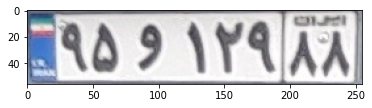

In [ ]:
root = './drive/MyDrive/task/'
plates = os.listdir(root + 'plates')
backgrounds = os.listdir(root + 'backgrounds')

image = cv2.imread(root + 'plates/P01.jpg')
plt.imshow(cv2.cvtColor(image, 2))

## Generating Data

In [ ]:
def BestRotation(rotateImage, angle):
    
    imgHeight, imgWidth = rotateImage.shape[1], rotateImage.shape[0]
  
    centreY, centreX = imgHeight//2, imgWidth//2

    rotationMatrix = cv2.getRotationMatrix2D((centreY, centreX), angle, 1.0)
  
    cosofRotationMatrix = np.abs(rotationMatrix[0][0])
    sinofRotationMatrix = np.abs(rotationMatrix[0][1])
  
    newImageHeight = int((imgHeight * sinofRotationMatrix) +
                         (imgWidth * cosofRotationMatrix))
    newImageWidth = int((imgHeight * cosofRotationMatrix) +
                        (imgWidth * sinofRotationMatrix))

    rotationMatrix[0][2] += (newImageWidth/2) - centreY
    rotationMatrix[1][2] += (newImageHeight/2) - centreX
  
    rotatingimage = cv2.warpAffine(rotateImage, rotationMatrix, (newImageWidth, newImageHeight))
    point1 = np.dot(rotationMatrix, np.array([[0,0,1]], np.float32).T)
    point2 = np.dot(rotationMatrix, np.array([[rotateImage.shape[1],0,1]], np.float32).T)
    point3 = np.dot(rotationMatrix, np.array([[rotateImage.shape[1],rotateImage.shape[0],1]], np.float32).T)
    point4 = np.dot(rotationMatrix, np.array([[0,rotateImage.shape[0],1]], np.float32).T)

    return (rotatingimage, point1, point2, point3, point4)

In [ ]:
train_data = []
train_labels = []
cnt = 0
for k in range(10):
  for k in range(len(plates)):
    background_index = np.random.randint(0,30)
    background = cv2.imread(os.path.join(root, 'backgrounds', backgrounds[background_index]))
    image = cv2.imread(os.path.join(root, 'plates', plates[k]))

    background = cv2.resize(background, (500, 500), interpolation=cv2.INTER_AREA)
    image = cv2.resize(image, (255, 75), interpolation=cv2.INTER_AREA)


    mask = np.zeros((image.shape[0],image.shape[1],3), dtype="uint8")
    mask[:] = (255,255,255)
    theta = np.random.randint(0,50)-25

    # rotate = imutils.rotate_bound(mask, theta)
    # plate = imutils.rotate_bound(image, theta)

    r1 = BestRotation(mask, theta)
    r2 = BestRotation(image, theta)
    rotate = r1[0]
    plate = r2[0]


    x_rand = np.random.randint(20, 200)
    y_rand = np.random.randint(20, 200)

    x1 = int(r1[1][0][0]) + y_rand 
    y1 = int(r1[1][1][0]) + x_rand  
    x2 = int(r1[2][0][0]) + y_rand 
    y2 = int(r1[2][1][0]) + x_rand  
    x3 = int(r1[3][0][0]) + y_rand 
    y3 = int(r1[3][1][0]) + x_rand  
    x4 = int(r1[4][0][0]) + y_rand 
    y4 = int(r1[4][1][0]) + x_rand  

    # print(x1, y1, x2, y2, x3, y3, x4, y4)

    test = cv2.bitwise_or(background[x_rand:x_rand+rotate.shape[0], y_rand:y_rand+rotate.shape[1]], rotate)
    background[x_rand:x_rand+rotate.shape[0], y_rand:y_rand+rotate.shape[1]] = test
    for i in range(rotate.shape[0]):
      for j in range(rotate.shape[1]):
        if (rotate[i,j] == [255, 255, 255]).all():
          background[i+x_rand,j+y_rand] = plate[i, j]
    train_data.append(background)
    train_labels.append((x1,y1,x2,y2,x3,y3,x4,y4))
  # plt.imshow(cv2.cvtColor(plate, 2))

1000
(161, 136, 416, 128, 418, 203, 163, 211)


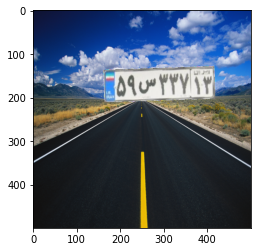

In [ ]:
print(len(train_data))
print(train_labels[0])
plt.imshow(cv2.cvtColor(train_data[0],2))
# print(train_data[3])

In [ ]:
i = 0
for image in train_data:
  cv2.imwrite(root+'images1/'+ f'N{i}.jpg', image )
  file = open(root + "txt/" + f'N{i}.txt',"w")
  (x1, y1, x2, y2, x3, y3, x4, y4) = train_labels[i]
  file.write(str(x1)+"\n")
  file.write(str(y1)+"\n")
  file.write(str(x2)+"\n")
  file.write(str(y2)+"\n")
  file.write(str(x3)+"\n")
  file.write(str(y3)+"\n")
  file.write(str(x4)+"\n")
  file.write(str(y4)+"\n")
  file.close()
  i+=1

In [ ]:
annot_path = os.listdir(root+'txt')
data = []
targets = []
filenames = []
for label in annot_path:
  file1 = open(root+'txt/' + label,"r+")
  (x1, y1, x2, y2, x3, y3, x4, y4) = (file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1])
  imagePath = root+'images1/'+label[0:-4]+'.jpg'
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  x1 = float(x1) / w
  y1 = float(y1) / h
  x2 = float(x2) / w
  y2 = float(y2) / h
  x3 = float(x3) / w
  y3 = float(y3) / h
  x4 = float(x4) / w
  y4 = float(y4) / h

  image = load_img(imagePath, target_size=(500, 500))
  image = img_to_array(image)

  data.append(image)
  targets.append((x1, y1, x2, y2, x3, y3, x4, y4))
  filenames.append(label[0:-4]+'.jpg')


In [ ]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [ ]:
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [ ]:
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(500, 500, 3)))

In [ ]:
model = Sequential()
model.add(mobilenet)
model.add(GlobalAvgPool2D())
model.add(Dense(512, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="sigmoid"))
mobilenet.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)               

In [ ]:
opt = Adam(lr=0.0001)
model.compile(loss="mse", optimizer=opt)


# save_best = tf.keras.callbacks.ModelCheckpoint("best_cnn_model.h5", save_best_only=True)

H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=60,
verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
29/29 [==============================] - 17s 464ms/step - loss: 0.0372 - val_loss: 0.0201
Epoch 2/60
29/29 [==============================] - 12s 419ms/step - loss: 0.0172 - val_loss: 0.0133
Epoch 3/60
29/29 [==============================] - 12s 418ms/step - loss: 0.0137 - val_loss: 0.0117
Epoch 4/60
29/29 [==============================] - 12s 419ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 5/60
29/29 [==============================] - 12s 421ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 6/60
29/29 [==============================] - 12s 420ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 7/60
29/29 [==============================] - 12s 420ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 8/60
29/29 [==============================] - 12s 419ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 9/60
29/29 [==============================] - 12s 420ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 10/60
29/29 [==============================] - 12s 419ms/step - loss: 0.0074 - val_lo

In [ ]:
save_path = root + "localization.h5"
model.save(save_path, save_format="h5")

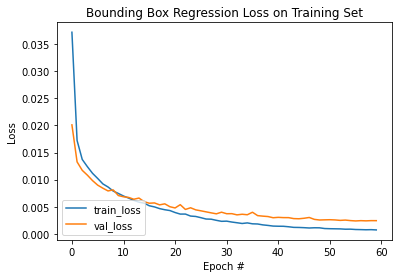

In [ ]:
N = H.params['epochs']
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## Fine Tuning

In [ ]:
# model = load_model(root + "localization.h5")

# model.trainable = True

# opt = Adam(lr=0.00001)
# model.compile(loss="mse", optimizer=opt)

# H = model.fit(
# trainImages, trainTargets,
# validation_data=(testImages, testTargets),
# batch_size=32,
# epochs=25,
# verbose=1)

In [ ]:
# N = H.params['epochs']
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.title("Bounding Box Regression Loss on Training Set")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss")
# plt.legend(loc="lower left")

In [ ]:
# save_path = root + "localization1.h5"
# model.save(save_path, save_format="h5")

## Inference

In [ ]:
model = load_model(root + "localization.h5")

In [ ]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(500, 500))
    image = img_to_array(image) / 255.0
    print('shape : ', image.shape)
    image = np.expand_dims(image, axis=0)
    print('shape : ', image.shape)

    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    return preds

In [ ]:
def warping(img, preds):
  image = np.copy(img)
  (x1, y1, x2, y2, x3, y3, x4, y4) = preds
  (h, w) = image.shape[:2]

  x1 = int(x1 * w)
  y1 = int(y1 * h)
  x2 = int(x2 * w)
  y2 = int(y2 * h)
  x3 = int(x3 * w)
  y3 = int(y3 * h)
  x4 = int(x4 * w)
  y4 = int(y4 * h)

  in_point = np.array([[x1,y1], [x2,y2], [x3, y3]], np.float32)
  out_point = np.array([[0,0], [255, 0], [255, 75]], np.float32)
  M = cv2.getAffineTransform(in_point, out_point)
  out_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
  return out_image

In [ ]:
def draw_bbox(img, preds, path):
    image = np.copy(img)
    (x1, y1, x2, y2, x3, y3, x4, y4) = preds
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    x3 = int(x3 * w)
    y3 = int(y3 * h)
    x4 = int(x4 * w)
    y4 = int(y4 * h)

    # draw the predicted bounding box on the image
    # cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    cv2.circle(image, (x1, y1), 8, (255, 0, 255), -1)    #-- top_left
    cv2.circle(image, (x2, y2), 8, (255, 0, 255), -1)    #-- bottom-left
    cv2.circle(image, (x3, y3), 8, (255, 0, 255), -1)    #-- top-right
    cv2.circle(image, (x4, y4), 8, (255, 0, 255), -1) 

    file1 = open(root+'txt/' + path + ".txt","r+")
    (x1, y1, x2, y2, x3, y3, x4, y4) = (file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1], file1.readline()[0:-1])
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    x3 = int(x3)
    y3 = int(y3)
    x4 = int(x4)
    y4 = int(y4)

    cv2.circle(image, (x1, y1), 8, (0, 0, 255), -1)    #-- top_left
    cv2.circle(image, (x2, y2), 8, (0, 0, 255), -1)    #-- bottom-left
    cv2.circle(image, (x3, y3), 8, (0, 0, 255), -1)    #-- top-right
    cv2.circle(image, (x4, y4), 8, (0, 0, 255), -1) 
    return image

shape :  (500, 500, 3)
shape :  (1, 500, 500, 3)


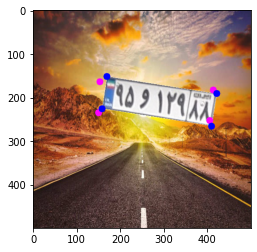

In [ ]:
imagePath = root+'images1/N63.jpg'
image = plt.imread(imagePath)
preds = inference(imagePath)
image_with_bbox = draw_bbox(image, preds, 'N63')

# show the output image
plt.imshow(image_with_bbox)

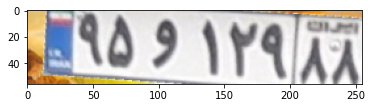

In [ ]:
warped = warping(image, preds)
res = cv2.resize(warped[0:75, 0:255], (255, 56))
# show the output image
plt.imshow(cv2.cvtColor(res, 1))

(56, 255)


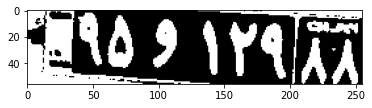

In [ ]:
# test = cv2.imread(root+'plates/P01.jpg',0)
# test1 = cv2.imread(root+'plates/P01.jpg')
test = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
test = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
# test1 = warped[0:75, 0:255]

thre,image_bin = cv2.threshold(test,-1,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print(test.shape)
plt.imshow(cv2.cvtColor(image_bin, 2))

In [ ]:
out_put = cv2.connectedComponentsWithStats(image_bin,8,cv2.CV_32S)
(numLabels, labels, stats, centroids) = out_put

stats

array([[   0,    0,  255,   56, 8646],
       [   0,    0,  139,   56, 1915],
       [ 130,    0,  125,   56,  572],
       [  39,    2,   18,   40,  369],
       [  61,    4,   20,   40,  461],
       [  96,    7,   18,   37,  392],
       [ 134,    8,   11,   41,  267],
       [ 154,    9,   21,   41,  385],
       [ 213,    8,   39,   10,  225],
       [ 178,   10,   19,   42,  418],
       [ 209,   21,   19,   35,  312],
       [ 232,   22,   20,   34,  314],
       [ 232,   29,    3,    2,    4]], dtype=int32)

5
[0, 1, 2, 8, 12]


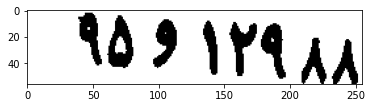

In [ ]:
mask = np.zeros_like(test)
k = 0
res = []
for i in range(numLabels):
    h = stats[i,2]
    w = stats[i,3]
    if h > w: 
        componentMask = (labels == i).astype("uint8") * 255
        mask = cv2.bitwise_or(mask,componentMask)
        k += 1
        res.append(i)
print(k)
print(res)
plt.imshow(mask,cmap='gray')

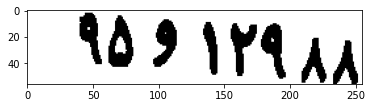

In [ ]:
str_el = np.ones((3,3)).astype(np.uint8)
out_image = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,str_el)
plt.imshow(out_image,cmap='gray')

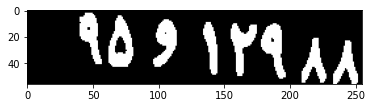

In [ ]:
thre,out_image = cv2.threshold(out_image,-1,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(out_image,cmap='gray')

19 33
19 34
19 42
20 40
11 40
18 36
19 39
17 39
9


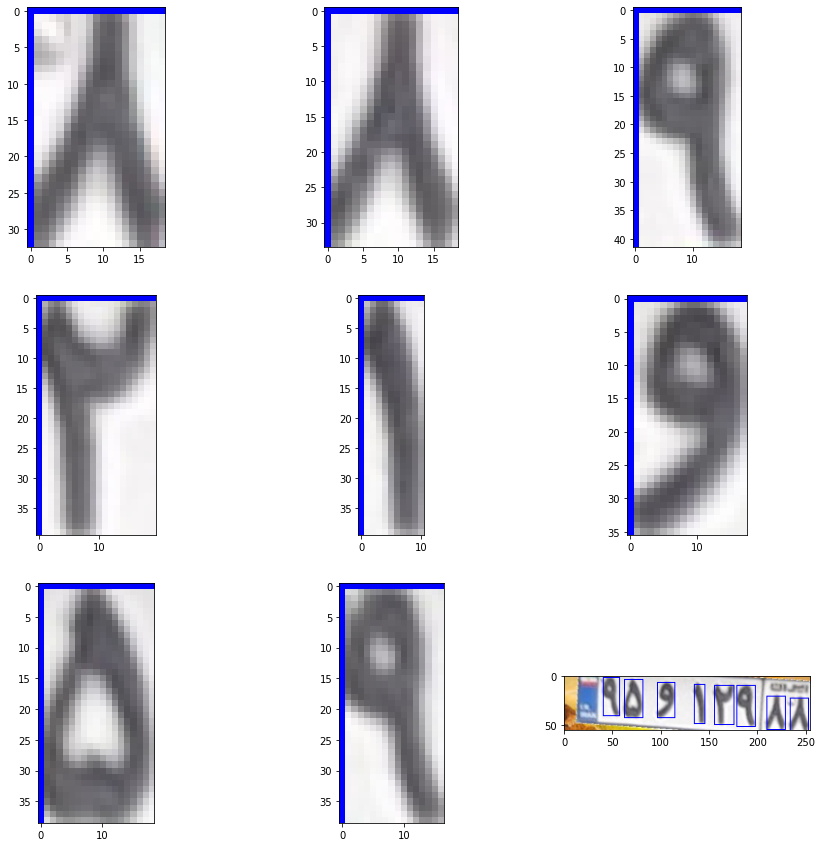

In [ ]:
test1 = cv2.resize(warped[0:75, 0:255], (255, 56))
contours_list, hierarchy = cv2.findContours(out_image,
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE) # Find contours
 

fig = plt.figure(figsize=(15, 15))
  
rows = 3
columns = 3
l = 1
for c in contours_list:
    x, y, w, h = cv2.boundingRect(c)
 
    # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 100:
        cv2.rectangle(test1, (x, y), (x + w, y + h), (0, 0, 255), 1)
        fig.add_subplot(rows, columns, l)
        print(w, h)
        plt.imshow(cv2.cvtColor(test1[y:y+h, x:x+w], 1))
        l+=1
        # break
fig.add_subplot(rows, columns, l)
plt.imshow(cv2.cvtColor(test1, 1))
print(l)

